In [1]:
# Enable autoreload of libraries on execution
%load_ext autoreload
%autoreload 2

In [ ]:
from IPython import get_ipython

def is_using_colab() -> bool:
    return "google.colab" in str(get_ipython())

In [ ]:
if is_using_colab():
  import zipfile
  from google.colab import drive
  import os

  # Copy code and datasets zips
  drive.mount('/content/drive')
  !cp -r "/content/drive/MyDrive/Master Thesis/." "."

  # Extract datasets zips
  for zip in os.listdir("Datasets"):
    with zipfile.ZipFile(os.path.join("Datasets", zip), 'r') as zip_ref:
      zip_ref.extractall(os.path.join("Datasets", zip.replace(".zip", "")))
    os.remove(os.path.join("Datasets", zip))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from media_utils import plot_img

import os
from tqdm import tqdm

import torch
import time
import cv2

# Dataset Handling


In [3]:
if is_using_colab():
  datasets_path = r"Datasets"
else:
  datasets_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple"

dataset_path = os.path.join(datasets_path, "simple_color_keyboard_2.bag")

## Dataset Inspection


### Inspect messages content


In [8]:
from dataset_utils import inspect_dataset
inspect_dataset(dataset_path)


Raw Image Event
header: 
  seq: 7397
  stamp: 
    secs: 1553513701
    nsecs: 651507593
  frame_id: ''
height: 260
width: 346
encoding: "mono8"
is_bigendian: 0
step: 346
data: [17, 13, 21, 16, 23, 18, 20, 9, 7, 0, 0...

Color Image Event
header: 
  seq: 0
  stamp: 
    secs: 1553513701
    nsecs: 651507593
  frame_id: ''
height: 260
width: 346
encoding: "bgr8"
is_bigendian: 0
step: 1038
data: [12, 68, 77, 12, 68, 77, 12, 68, 75, 0, 70...

Events Event
header: 
  seq: 8018
  stamp: 
    secs: 1553513701
    nsecs: 673390593
  frame_id: ''
height: 260
width: 346
events: 
  - 
    x: 89
    y: 147
    ts: 
      secs: 1553513701
      nsecs: 653394593
    polarity: True
  - 
    x: 328
    y: 167
    ts: 
      secs: 1553513701
      nsecs: 65339559...



##### **Image events content:**

**data**: binary image data encoded according to encoding

**encoding**: format used to encode the image data - e.g. mono8, bgr8

**width**, **height**: size of the image

**is_bigendian**: endianness of image

**step**: full row length in bytes

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Event events content:**

**events**: array of events

**width**, **height**: size of the camera sensor

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Events format:**

**x**, **y**: coordinates of the pixel sensor

**polarity**: polarity of the event in {True, False}

**ts**:

-   **secs**: seconds since epoch
-   **nsecs**: nanoseconds since ts.secs


### Inspect message timestamps


In [40]:
from dataset_utils import inspect_message_timestamps
inspect_message_timestamps(dataset_path)


     Topic Name          Event Timestamp
  0) /dvs/image_color    1553513701.6515076
  1) /dvs/events         1553513701.6733906
                         First event timestamp 1553513701.6533947 Last event timestamp 1553513701.6833866
  2) /dvs/image_color    1553513701.6848307
  3) /dvs/events         1553513701.7133887
                         First event timestamp 1553513701.6833887 Last event timestamp 1553513701.7233865
  4) /dvs/image_color    1553513701.7181535
  5) /dvs/events         1553513701.7433887
                         First event timestamp 1553513701.7233896 Last event timestamp 1553513701.7533855
  6) /dvs/image_color    1553513701.7514765
  7) /dvs/events         1553513701.7733886
                         First event timestamp 1553513701.7533886 Last event timestamp 1553513701.7833867
  8) /dvs/image_color    1553513701.7847996
  9) /dvs/events         1553513701.8133895
                         First event timestamp 1553513701.7833886 Last event timestamp 15535137

The events are not completely sequential, since there can be two image events after each other (e.g. 6-7) but the first event timestamp of the next event is before the last image (e.g 8).

Moreover, there are some events that are acquired after the last image has been captured.


## Dataset Loading


In [43]:
# Download datasets if using Colab
if is_using_colab():
    import gdown

    datasets = {
        'simple_color_keyboard_2.zip': 'https://drive.google.com/uc?id=1hGdQ0WLGUjYA6snH-i1WY1zTm7HPDG9D&confirm=t',
        'simple_jenga_destroy.zip': 'https://drive.google.com/uc?id=1KqqJzcdhOF1h0TuKTXUfLjY1vhL28Dtl&confirm=t'
    }

    for name, url in datasets.items():
        gdown.download(url, name)
        !unzip name -d name.replace(".zip", "")

In [44]:
from dataset_utils import load_bag_as_dataframes
events_df, images_df = load_bag_as_dataframes(dataset_path, image_type="color")
print("Events dataframe")
display(events_df)
print("Images dataframe")
display(images_df)


100%|██████████| 480/480 [00:36<00:00, 13.19it/s]


Events dataframe


,seq,x,y,secs,polarity
0,8018,89,147,1.553514e+09,True
1,8018,328,167,1.553514e+09,False
2,8018,52,48,1.553514e+09,True
3,8018,272,70,1.553514e+09,True
4,8018,140,68,1.553514e+09,True
...,...,...,...,...,...
5805599,8177,5,83,1.553514e+09,True
5805600,8177,246,165,1.553514e+09,False
5805601,8177,109,81,1.553514e+09,True
5805602,8177,193,69,1.553514e+09,False


Images dataframe


,seq,secs,width,height,is_bigendian,encoding,step,data
0,0,1.553514e+09,346,260,0,bgr8,1038,"[12, 68, 77, 12, 68, 77, 12, 68, 75, 0, 70, 70..."
1,1,1.553514e+09,346,260,0,bgr8,1038,"[21, 70, 75, 21, 70, 75, 12, 68, 73, 0, 68, 68..."
2,2,1.553514e+09,346,260,0,bgr8,1038,"[0, 66, 68, 0, 66, 68, 0, 61, 66, 0, 52, 61, 0..."
3,3,1.553514e+09,346,260,0,bgr8,1038,"[0, 68, 66, 0, 68, 66, 0, 66, 61, 0, 49, 58, 0..."
4,4,1.553514e+09,346,260,0,bgr8,1038,"[0, 61, 61, 0, 61, 61, 0, 49, 58, 0, 33, 52, 0..."
...,...,...,...,...,...,...,...,...
155,155,1.553514e+09,346,260,0,bgr8,1038,"[0, 0, 28, 0, 0, 28, 0, 12, 28, 0, 21, 33, 0, ..."
156,156,1.553514e+09,346,260,0,bgr8,1038,"[0, 21, 33, 0, 21, 33, 0, 21, 33, 0, 28, 33, 0..."
157,157,1.553514e+09,346,260,0,bgr8,1038,"[0, 0, 21, 0, 0, 21, 0, 0, 0, 0, 0, 21, 0, 21,..."
158,158,1.553514e+09,346,260,0,bgr8,1038,"[0, 0, 28, 0, 0, 28, 0, 0, 38, 0, 0, 33, 0, 0,..."


## Dataset Analysis


Events and frames are already ordered by timestamp, since they are produced from a real simulation.


### Number of events per image frame

Check how many events there are among each image frame.

This roughly reflects the amount of movement in the sequence.


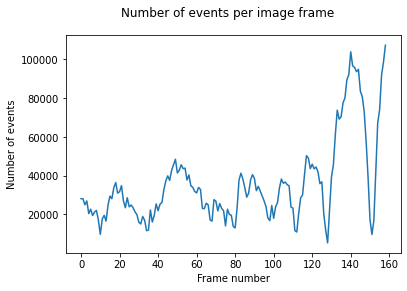

In [45]:
from dataset_utils import plot_number_of_events_per_frame
plot_number_of_events_per_frame(events_df, images_df)


### Check image frames frequency


Average milliseconds: 33.3231, Average fps: 30.01


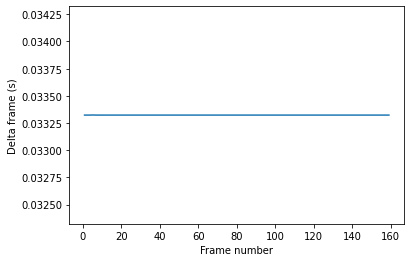

In [46]:
from dataset_utils import plot_image_frames_frequency
plot_image_frames_frequency(images_df)

### Save events for visualization


In [ ]:
from media_utils import save_visual_events

w, h = images_df.iloc[0].width, images_df.iloc[0].height
folder_name = os.path.basename(dataset_path).replace(".bag", "")
output_dir = os.path.join(os.path.dirname(dataset_path), folder_name)
save_visual_events(events_df, w, h, output_dir)

## Dataset Preparation


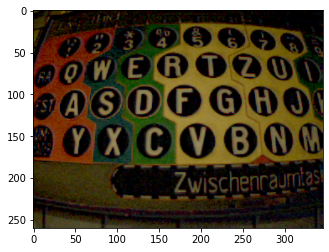

(10, 260, 346)


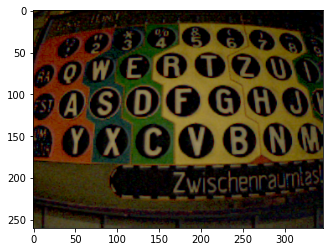

In [52]:
from dataset_utils import dataset_generator_from_batches
batches_path = os.path.join(dataset_path.replace(".bag", ""), "batches")
for batch in dataset_generator_from_batches(batches_path):
    (in_, events), out_ = batch
    plot_img(in_)
    print(events.shape)
    plot_img(out_)
    break


## PyTorch Dataset and DataLoader


In [7]:
from dataset import CEDDataset, ConcatBatchSampler
train_datasets_names = [
    # "simple_carpet",
    "simple_color_keyboard_1",
    # "simple_color_keyboard_2",
    "simple_fruit",
    # "simple_jenga_1",
    "simple_jenga_destroy",
    "simple_objects",
    # "simple_rabbits",
    # "simple_wires_1",
    "simple_wires_2",
]


datasets = [
    CEDDataset(os.path.join(datasets_path, ds, "batches"), limit=16) for ds in datasets_names
]
concat_ds = torch.utils.data.ConcatDataset(train_datasets_names)
# samplers = [torch.utils.data.RandomSampler(ds) for ds in train_datasets]
# sampler = ConcatBatchSampler(samplers=samplers, batch_size=64, drop_last=False)
# train_dataloader = torch.utils.data.DataLoader(
#     concat_ds, batch_sampler=sampler, num_workers=0,
# )
train_dataloader = torch.utils.data.DataLoader(
    concat_ds,  batch_size=64, shuffle=True,
)


In [ ]:
# Inspect train dataloader
from media_utils import save_video_tensors
frames = []
for (i, e), o in train_dataloader:
  for batch in o:
    frames.append(batch)

save_video_tensors("train_frames.mp4", frames, 5)

# UNet AutoEncoder Model


In [ ]:
from torchsummary import summary
from models import EventsToImagesUNet

input_channels = 3 + 10
model = EventsToImagesUNet(input_channels).to("cpu")
summary(model, input_size=(input_channels, 256, 336), device="cpu")


## Model Training


In [ ]:
from train import train_unet

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = EventsToImagesUNet(input_channels).to(device)
n_epochs = 10
train_unet(model, device, train_dataloader, n_epochs)

In [ ]:
torch.save(model.state_dict(), "model_thesis.pt")

In [ ]:
# Save input frames as video
from media_utils import save_video_tensors
imgs = []
for batch in tqdm(train_dataloader):
    (input_images, events_tensors), ground_truth_images = batch
    imgs += input_images
save_video_tensors("input_video.mp4", imgs, 30)


In [ ]:
# Save generated frames as video
use_prev_images_as_input = False

imgs = []
for i, batch in enumerate(tqdm(train_dataloader)):
    if use_prev_images_as_input and i != 0:
        input_images = generated_images
    else:
        (input_images, events_tensors), ground_truth_images = batch
    input_images = torch.einsum("bhwc -> bchw", input_images)

    input_tensors = torch.hstack((input_images, events_tensors))
    input_tensors = input_tensors.to(device)

    generated_images = model(input_tensors).cpu().detach()
    generated_images = torch.einsum("bchw -> bhwc", generated_images)

    imgs += generated_images

save_video_tensors("generated_video.mp4", imgs, 30)


In [ ]:
# BS = 1; Seconds for one epoch: 142.36227083206177
# BS = 2; Seconds for one epoch: 132.93124723434448
# BS = 4; Seconds for one epoch: 127.95218682289124
# BS = 8; Seconds for one epoch: 138.49955368041992
# BS = 16; Seconds for one epoch: after 180 seconds it was at 3/10 batches so I stopped it


# Transformer Model


## Model definition


In [ ]:
del model
torch.cuda.empty_cache()
import gc
gc.collect()

In [5]:
from models import TransformerModel
input_shape = (336, 256, 3)

encoding_size = 512
heads = 4
layers_number = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model = TransformerModel(input_shape, encoding_size, heads, layers_number).to(device)


## Model Training


In [ ]:
from train import train_transformer

params = {
    "n_epochs": 250,
    "learning_rate": 0.0001
}
train_transformer(model, device, train_dataloader, params)

In [14]:
# Save model
torch.save(model.state_dict(), "model.pt")


In [38]:
# Load Model
model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

In [30]:
# Define test dataset
from media_utils import save_video_tensors
test_datasets_names = [
    # "simple_carpet",
    # "simple_color_keyboard_1",
    "simple_color_keyboard_2",
    # "simple_fruit",
    "simple_jenga_1",
    # "simple_jenga_destroy",
    # "simple_objects",
    "simple_rabbits",
    "simple_wires_1",
    # "simple_wires_2",
]
test_datasets = [
    CEDDataset(os.path.join(datasets_path, ds, "batches"), limit=16) for ds in test_datasets_names
]
concat_ds = torch.utils.data.ConcatDataset(test_datasets)
samplers = [torch.utils.data.SequentialSampler(ds) for ds in test_datasets]
sampler = ConcatBatchSampler(samplers=samplers, batch_size=64, drop_last=False)
test_dataloader = torch.utils.data.DataLoader(
    concat_ds, batch_sampler=sampler, num_workers=0,
)

In [ ]:
# Inspect test dataloader
frames = []
for (i, e), o in test_dataloader:
  for batch in o:
    frames.append(batch)

save_video_tensors("test_frames.mp4", frames, 5)

In [ ]:
# Save video results on train and test set
from media_utils import save_predicted_video
save_predicted_video(model, device, train_dataloader, "train_prediction.mp4")
save_predicted_video(model, device, test_dataloader, "test_prediction.mp4")

In [41]:
# Save events + image visualization
from media_utils import bgr_to_rgb
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
out = cv2.VideoWriter("train_with_img.mp4", fourcc, 30, (336 * 2, 256))

for (img_in, events), img_out in tqdm(train_dataloader):
    for i, batch in enumerate(events):
        img = img_out[i]
        for bin_ in batch:
            bin_ = torch.repeat_interleave(bin_.reshape(256, 336, 1), 3, dim=2)
            frame = cv2.cvtColor(
                (bin_ * 255).numpy().astype(np.uint8), cv2.COLOR_RGB2BGR
            )
            frame = np.hstack((frame, bgr_to_rgb((img * 255).numpy()).astype(np.uint8)))
            out.write(frame)

out.release()


100%|██████████| 29/29 [03:49<00:00,  7.91s/it]


In [ ]:
# Eval on train
model.eval()
eval_events = []

for train_ds in train_datasets:
  (in_img, events), out_img = next(iter(train_ds))
  eval_events.append(torch.tensor(events.reshape(1, 10, 256, 336)))

for ev in eval_events:
  out = model(ev[:1].to(device))
  plt.imshow(np.einsum("chw -> hwc", out[0].detach().cpu().numpy()))
  plt.show()

In [ ]:
# Eval on test
model.eval()
eval_events = []

for test_ds in test_datasets:
  (in_img, events), out_img = next(iter(test_ds))
  eval_events.append(torch.tensor(events.reshape(1, 10, 256, 336)))

random_tensor = torch.tensor(np.random.rand(1, 10, 256, 336).astype(np.float32))
eval_events.append(random_tensor)

for ev in eval_events:
  out = model(ev[:1].to(device))
  plt.imshow(np.einsum("chw -> hwc", out[0].detach().cpu().numpy()))
  plt.show()
